In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
import datetime

In [2]:
folder_path = os.path.join("..","Fall2024Data")
flash_data_raw = os.path.join(folder_path, "ASCEND_DATA_2024_11_25_19_13_57.csv")
data2 = os.path.join(folder_path, "DATA2.CSV")
data3 = os.path.join(folder_path, "DATA3.CSV")
data4 = os.path.join(folder_path, "DATA4.CSV")
geiger_data = os.path.join(folder_path, "RadiaCode Log.txt")
geiger_spectrum_xml = os.path.join(folder_path, "RadiaCode_ Spectrum.xml")

aprs_data_csv = os.path.join(folder_path, "aprsfi_KA7NSR-9_data.csv")

# create directory for processed files:
temp_folder = "F24Processed"
os.makedirs(temp_folder, exist_ok=True)

# folder to store graphs
graph_folder = "Graphs"
os.makedirs(graph_folder, exist_ok=True)

In [3]:
flash_data = os.path.join(temp_folder, "flash_data_header.csv")
custom_na = pd._libs.parsers.STR_NA_VALUES
custom_na.add("-")
flash_df = pd.read_csv(flash_data, skipinitialspace=True, na_values=custom_na)
print(list(flash_df.columns))

['Receive time', 'Header', 'Millis', 'PCFTime', 'BMETemp(C)', 'BMEPress(hPa)', 'BMEHum(%)', 'BMEGas(KOhms)', 'BMEAlt(m)', 'INACurr(mA)', 'INAVolt(mV)', 'INAPow(mW)', 'LSM9DS1 AccX', 'LSM9DS1 AccY', 'LSM9DS1 AccZ', 'LSM9DS1 GyroX', 'LSM9DS1 GyroY', 'LSM9DS1 GyroZ', 'LSM9DS1 MagX', 'LSM9DS1 MagY', 'LSM9DS1 MagZ', 'PicoTemp(C)', 'ICM AccX', 'ICM AccY', 'ICM AccZ', 'ICM GyroX', 'ICM GyroY', 'ICM GyroZ', 'ICM MagX', 'ICM MagY', 'ICM MagZ', 'ICM TempC', 'Unnamed: 32']


In [4]:
aprs_df = pd.read_csv(aprs_data_csv)
print(list(aprs_df.columns))

def to_mst(utc):
    parts = utc.split(":")
    parts[0] = str(int(parts[0]) - 7)
    return ":".join(parts)

['time', 'lasttime', 'lat', 'lng', 'speed', 'course', 'altitude', 'comment']


In [5]:
# setting up arrays
"""
radio got 
5:1:19 at 9:46:55
5:2:18 at 9:47:58
from one to the other 
hours + 5
minues + 45
seconds + 40 (hard to track) 
"""
def fixTime(bad_time):
    tokens = bad_time.split(":")
    return f"{(int(tokens[0])+12)%24}:{(int(tokens[1])+0)%60}:{(int(tokens[2])+0)%60}"

wind_speed = []
course = []
pres = []
temp = []
rel_hum = [] 

data_index = 0 
last_pres = 10000
for i in range(len(aprs_df["speed"])):
    target_time = datetime.datetime.strptime((aprs_df["time"][i].split()[1]), "%H:%M:%S")
    index_time = target_time
    while target_time >= index_time and data_index < len(flash_df["PCFTime"])-1:
        raw = flash_df["PCFTime"][data_index]
        if(str(raw) == "nan"):
          data_index += 1
          continue
        # print(target_time, index_time, data_index, raw, sep="\t")
        try:
            index_time = datetime.datetime.strptime(fixTime(raw.split()[1]), "%H:%M:%S")
        except Exception as e:
            pass
        finally: 
            data_index += 1
    data_index -= 1

    if(flash_df["BMEPress(hPa)"][data_index] > last_pres or flash_df["BMEHum(%)"][data_index] == 0):
        continue
    
    if str(flash_df["BMEPress(hPa)"][data_index]) == "nan": break
    
    
    wind_speed.append(aprs_df["speed"][i] * 0.2777778)
    course.append(aprs_df["course"][i])
    pres.append(flash_df["BMEPress(hPa)"][data_index])
    last_pres = flash_df["BMEPress(hPa)"][data_index]
    
    temp.append(flash_df["BMETemp(C)"][data_index])
    rel_hum.append(flash_df["BMEHum(%)"][data_index] / 100)
    data_index += 1
        
    print(target_time, index_time, data_index, wind_speed[-1], course[-1], pres[-1], temp[-1], rel_hum[-1])
    
    if(flash_df["BMEPress(hPa)"][data_index] < 100): break

 
print(len(wind_speed), len(course), len(pres), len(temp), len(rel_hum), sep="\t")
print("Speed", "Course", "Pres", "Temp", "Rel Hum", sep="\t")
for i in range(len(wind_speed)):
    print(round(wind_speed[i], 2), course[i], pres[i], temp[i], round(rel_hum[i], 4), sep="\t")
    

1900-01-01 16:05:26 1900-01-01 16:05:27 435 6.1111116 59 950.9 19.91 0.1612
1900-01-01 16:23:26 1900-01-01 16:23:27 2389 22.222224 96 717.8 22.08 0.0118
1900-01-01 16:25:26 1900-01-01 16:25:27 2605 27.777780000000003 90 646.43 19.69 0.0225
1900-01-01 16:26:56 1900-01-01 16:26:57 2767 39.7222254 91 595.87 17.74 0.028900000000000002
1900-01-01 16:27:26 1900-01-01 16:27:27 2821 36.3888918 100 579.39 16.95 0.053099999999999994
1900-01-01 16:28:26 1900-01-01 16:28:27 2929 41.66667 90 547.46 15.28 0.0567
1900-01-01 16:29:26 1900-01-01 16:29:27 3037 47.777781600000004 104 516.96 13.65 0.0403
1900-01-01 16:30:56 1900-01-01 16:30:58 3201 29.7222246 103 471.36 10.22 0.0388
1900-01-01 16:31:26 1900-01-01 16:31:27 3255 36.3888918 106 456.51 8.92 0.028300000000000002
1900-01-01 16:33:56 1900-01-01 16:33:57 3525 35.5555584 85 389.08 4.17 0.002
1900-01-01 16:34:26 1900-01-01 16:34:27 3579 36.3888918 94 376.04 3.06 0.0006
1900-01-01 17:12:56 1900-01-01 17:12:58 7571 30.277780200000002 93 14.68 -20.81 

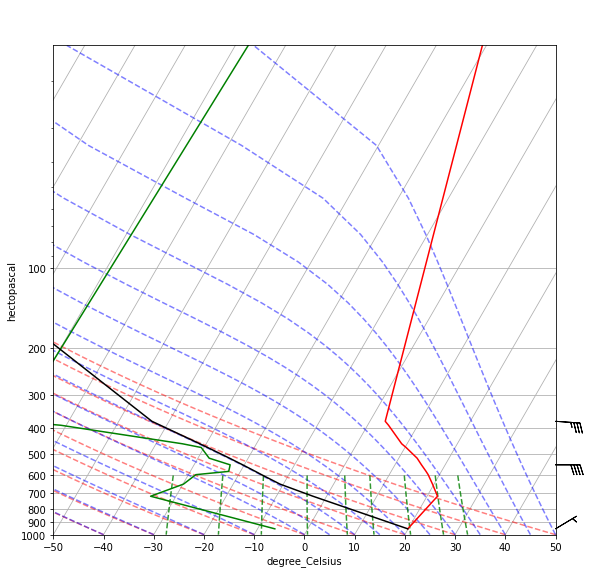

In [6]:
# skewT
fig = plt.figure(figsize = (9,9))
skew = SkewT(fig=fig, aspect='auto')

pres = np.array(pres) * units.hPa
temp = np.array(temp) * units.degC
rel_hum = np.array(rel_hum) * units.dimensionless
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature=temp, relative_humidity=rel_hum)

prof = mpcalc.parcel_profile(pres, temp[0], dewpoint[0]).to('degC')

# # fix with aprs data 
# u = wind_speed * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

wind_speed = np.array(wind_speed) * units("m/s")
course = np.array(course) * units.deg

u, v = mpcalc.wind_components(wind_speed, course)
# u = np.linspace(-10, 10, len(pres)) * units.knots
# v = np.linspace(-20, 20, len(pres)) * units.knots

skew.plot(pres, temp, 'r')
skew.plot(pres, dewpoint, 'g')
skew.plot(pres, prof, 'k')
skew.plot_barbs(pres[::5], u[::5], v[::5])

skew.ax.set_xlim(-50, 50)
skew.ax.set_ylim(1000, min(pres))

skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

plt.savefig(os.path.join(graph_folder, f"skewTLogP.svg"))
plt.savefig(os.path.join(graph_folder, f"skewTLogP.png"))

plt.show()